# Tutorial: Predicting Habitable Planets Using Shallow Learning Models

In this tutorial, we apply simple shallow learning models—including the **Perceptron**, **Adaline (GD)**, and **Adaline (SGD)** to a real-world binary classification problem: determining whether an exoplanet is potentially habitable.

The data comes from the **[Habitable Worlds Catalog](http://phl.upr.edu/projects/habitable-exoplanets-catalog)** maintained by the Planetary Habitability Laboratory. Our goal is to use basic physical features to train models that can distinguish between planets that are habitable and those that are not.

## Motivation: Are We Alone?

The human fascination with life beyond Earth is timeless. Over the past decade, astronomical missions such as **Kepler**, **K2**, and **TESS** have helped us discover over 5,000 confirmed exoplanets. Some of these worlds might possess the right conditions to support life.

Our machine learning journey begins with this scientific question:  
**Can we teach an algorithm to identify potentially habitable planets using just a few features?**

---

## The Dataset

We use a simple dataset with 18 labeled exoplanets. Each planet is described by:

- **Stellar Mass (in solar masses)**
- **Orbital Period (in days)**
- **Distance to Star (in astronomical units, AU)**
- ...  

---

## The Habitable Zone

![Figure 2.1](./hwc_hz.png)

This Figure shows planets plotted by stellar temperature and planet flux. The green shaded regions represent the **habitable zones**:

- **Dark green**: Conservative estimate
- **Light green**: Optimistic estimate

The circle sizes correspond to planetary radii. This visualization helps illustrate where planets lie in relation to the habitable zone based on their energy intake.

The figure, reproduced with permission from the Planet Habitability Lab (University of Puerto Rico Arecibo), underscores the importance of stellar temperature and flux—both of which depend on the features we’re using!

---

## Step 1: Load and Clean the Data

We begin our analysis by loading a **simplified version** of the dataset from the [Habitable Worlds Catalog](http://phl.upr.edu/projects/habitable-exoplanets-catalog).  
This dataset contains basic physical characteristics for a curated set of planets. The full catalog includes **over 5,000 exoplanets**, but here we’re working with a smaller, more manageable subset to demonstrate shallow learning techniques.

### 🧾 What’s in the Data?

The file `hwc_table_all.csv` contains many columns, including:

- **Planet name** and other identifiers (non-numeric)
- **Stellar properties** (mass, temperature, radius)
- **Orbital parameters**

Before training models, we must ensure the data is clean and ready.

---

### Data Cleaning Steps

1. **Drop non-numeric columns**  
   Machine learning models require numerical input. Columns like planet names, discovery references, or notes must be excluded.  
   (You can keep them separately for display or interpretation.)

2. **Drop rows with missing values (NaNs)**  
   Many entries in the catalog may lack certain measurements (like temperature or radius). These are marked as `NaN` (Not a Number).  
   To avoid errors or poor model performance, we remove these rows.

> **In a real-world scenario, you might use imputation, interpolation, or predictive filling—but here we’ll `drop NaNs` for simplicity**.

---

In [1]:
import pandas as pd

# Load the data
df = pd.read_csv('hwc_table_all.csv')

# View basic info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Name                            70 non-null     object 
 1   Type                            70 non-null     object 
 2   Detection Method                70 non-null     object 
 3   Mass<br>(M<sub>E</sub>)         70 non-null     float64
 4   Radius<br>(R<sub>E</sub>)       70 non-null     float64
 5   Flux<br>(S<sub>E</sub>)         70 non-null     float64
 6   <i>T<sub>surf</sub></i><br>(K)  70 non-null     float64
 7   Period<br>(days)                70 non-null     float64
 8   Distance<br>(ly)                70 non-null     float64
 9   Age<br>(Gy)                     49 non-null     float64
 10  ESI                             70 non-null     float64
dtypes: float64(8), object(3)
memory usage: 6.1+ KB
None


In [2]:
# Look at the Data
print(df.head())

        Name                Type Detection Method  Mass<br>(M<sub>E</sub>)  \
0  TOI-904 c  M Warm Superterran          Transit                    5.340   
1  TOI-700 e       M Warm Terran          Transit                    0.818   
2  TOI-700 d       M Warm Terran          Transit                    1.250   
3   GJ 357 d  M Warm Superterran  Radial Velocity                    6.100   
4  GJ 3293 d  M Warm Superterran  Radial Velocity                    7.600   

   Radius<br>(R<sub>E</sub>)  Flux<br>(S<sub>E</sub>)  \
0                      2.167                 0.524434   
1                      0.953                 1.278049   
2                      1.073                 0.859827   
3                      2.340                 0.382595   
4                      2.670                 0.588593   

   <i>T<sub>surf</sub></i><br>(K)  Period<br>(days)  Distance<br>(ly)  \
0                      244.820750          83.99970        150.322365   
1                      305.688111         

In [3]:
# Drop non-numeric columns
df_numeric = df.select_dtypes(include=['number'])
# OR you can do
#df_numeric = df.drop(labels=["Type", "Detection Method"], axis=1)

# Drop rows with missing values
df_clean = df_numeric.dropna().copy()

print(f"Cleaned dataset shape: {df_clean.shape}")

Cleaned dataset shape: (49, 8)


In [31]:
# Look at the cleaned data
print(df_clean.head())

   Mass<br>(M<sub>E</sub>)  Radius<br>(R<sub>E</sub>)  \
0                    5.340                      2.167   
1                    0.818                      0.953   
2                    1.250                      1.073   
7                   25.300                      1.367   
8                    5.600                      1.730   

   Flux<br>(S<sub>E</sub>)  <i>T<sub>surf</sub></i><br>(K)  Period<br>(days)  \
0                 0.524434                      244.820750         83.999700   
1                 1.278049                      305.688111         27.809780   
2                 0.859827                      276.939259         37.423960   
7                 0.908576                      280.876792          8.457463   
8                 0.425226                      232.236106         24.737230   

   Distance<br>(ly)  Age<br>(Gy)       ESI  
0        150.322365          1.5  0.658603  
1        101.520947          1.5  0.912032  
2        101.520947          1.5  0.94117

## Step 2: Understanding and Using the Earth Similarity Index (ESI)

One of the key columns in the dataset is the **Earth Similarity Index (ESI)**.

The **Earth Similarity Index** is a number between 0 and 1 that quantifies **how similar a planet is to Earth** based on physical parameters like:

- Radius
- Density
- Escape velocity
- Surface temperature

The formula is a geometric mean of normalized differences between Earth’s values and the planet’s values for each parameter.

- **ESI = 1** means **identical to Earth**
- **ESI ≈ 0** means **very dissimilar to Earth**

Although ESI doesn't guarantee habitability, it's often used as a **proxy** when atmospheric or biological data is unavailable.

---

### Defining Our Target Variable `y`

To apply supervised classification, we need a binary label.  
We will use a simple threshold on ESI to define **habitability**:

In [4]:
# Define habitability
df_clean['ESI'] = (df_clean['ESI'] > 0.75).astype(int)
# Rename ESI to label
df_clean.rename(columns={'ESI': 'label'}, inplace=True)

In [5]:
df_clean.columns

Index(['Mass<br>(M<sub>E</sub>)', 'Radius<br>(R<sub>E</sub>)',
       'Flux<br>(S<sub>E</sub>)', '<i>T<sub>surf</sub></i><br>(K)',
       'Period<br>(days)', 'Distance<br>(ly)', 'Age<br>(Gy)', 'label'],
      dtype='object')

## Training a Preceptron Model

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from models import Perceptron  # Make sure models.py is in the same directory


# Now define feature matrix X and target vector y
X = df_clean.iloc[:, :-1].values 
y = df_clean.iloc[:, -1].values

# Split the dataset into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize and train the Perceptron
ppn = Perceptron(eta=0.01, n_epochs=10, random_state=1)
ppn.fit(X_train, y_train)

Test Accuracy: 0.50


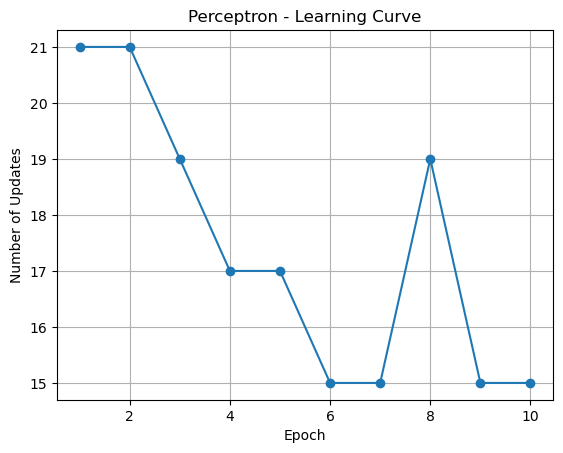

In [7]:
# Evaluate the model
from sklearn.metrics import accuracy_score

y_pred = ppn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.2f}")

# Optional: Plot training errors per epoch
import matplotlib.pyplot as plt

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Number of Updates')
plt.title('Perceptron - Learning Curve')
plt.grid(True)
plt.show()

### Visualizing the Decision Boundary (Flux vs. Surface Temperature)

To better understand how our Perceptron model separates habitable and non-habitable planets, we plot its **decision boundary** using just two features:

- **Flux** (S<sub>E</sub>): The amount of energy the planet receives from its star.
- **Surface Temperature** (K): The estimated surface temperature of the planet.

These two features are directly related to whether a planet could support liquid water, making them ideal for visualization.

We:

1. Extract only the flux and surface temperature columns from the cleaned dataset.
2. Train a new Perceptron model using only these two features.
3. Plot the decision boundary using our `plot_decision_regions` function.

This helps us visually inspect how well the model separates the two classes (habitable vs. non-habitable) in this 2D feature space.


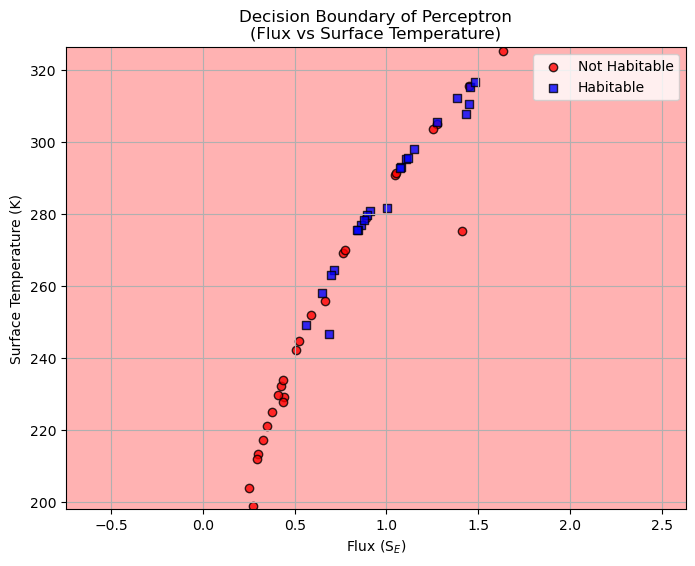

In [ ]:
# Import the necessary method
from models import plot_decision_regions

import matplotlib.pyplot as plt

# Select only 'Flux' and 'Surface Temperature' as input features
# Be careful to match column names exactly (including HTML formatting!)
X_vis = df_clean[['Flux<br>(S<sub>E</sub>)', '<i>T<sub>surf</sub></i><br>(K)']].values
y_vis = df_clean['label'].values

# Optional: Normalize the features if ranges are very different
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_vis = scaler.fit_transform(X_vis)

# Re-train the model only on the two selected features (for plotting)
from models import Perceptron

ppn_vis = Perceptron(eta=0.01, n_epochs=50, random_state=1)
ppn_vis.fit(X_vis, y_vis)

# Plot decision regions
plt.figure(figsize=(8, 6))
plot_decision_regions(X_vis, y_vis, classifier=ppn_vis, class_names=["Not Habitable", "Habitable"])
plt.xlabel("Flux (S$_E$)")
plt.ylabel("Surface Temperature (K)")
plt.title("Decision Boundary of Perceptron\n(Flux vs Surface Temperature)")
plt.legend(loc="best")
plt.grid(True)
plt.show()


## Training a Model: Adaline (Batch Gradient Descent)

Now we train an **AdalineGD** model (ADAptive LInear NEuron using batch gradient descent).

Unlike the Perceptron, which updates weights only for misclassified points, **Adaline** uses the **continuous output** of the model and applies **gradient descent** to minimize the **mean squared error (MSE)** between predictions and true labels.

### Training Steps

1. Initialize Adaline with a learning rate and number of epochs.
2. Fit the model on the training data.
3. Predict labels on the test data.
4. Compute the test accuracy.
5. Plot the learning curve (MSE over epochs).

### Evaluation

We also compute the accuracy of the model on unseen test data to evaluate its generalization performance.


Test Accuracy (AdalineGD): 0.50


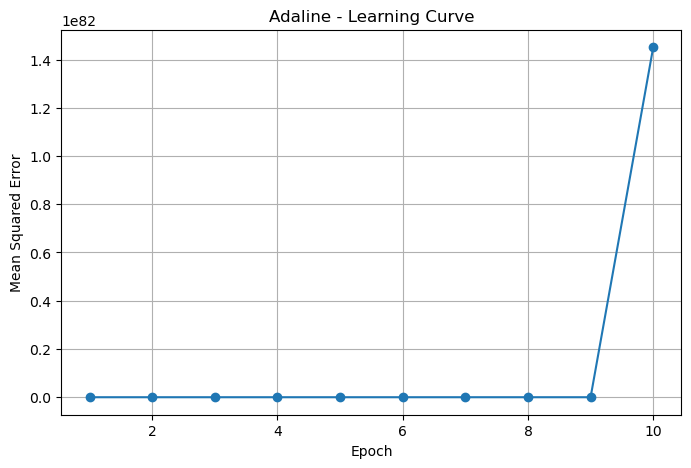

In [58]:
# Import AdalineGD
from models import AdalineGD  # make sure AdalineGD is in models.py

# Now define feature matrix X and target vector y
X = df_clean.iloc[:, :-1].values 
y = df_clean.iloc[:, -1].values

# Split the dataset into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize and train AdalineGD
ada = AdalineGD(eta=0.01, n_iter=10, random_state=1)
ada.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import accuracy_score

y_pred_ada = ada.predict(X_test)
acc_ada = accuracy_score(y_test, y_pred_ada)
print(f"Test Accuracy (AdalineGD): {acc_ada:.2f}")

# Plot learning curve (MSE loss per epoch)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Adaline - Learning Curve')
plt.grid(True)
plt.show()


### What about using Feature Normalization ?!

Test Accuracy (AdalineGD): 50.00 %


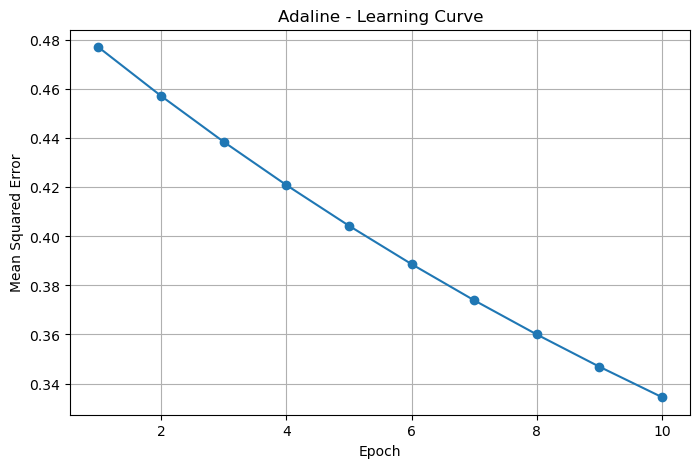

In [71]:
# Define feature matrix X and target vector y
X = df_clean.iloc[:, :-1].values 
y = df_clean.iloc[:, -1].values

# Split the dataset into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalize the features if ranges are very different
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train AdalineGD
ada = AdalineGD(eta=0.01, n_iter=10, random_state=1)
ada.fit(X_train, y_train)

y_pred_ada = ada.predict(X_test)
acc_ada = accuracy_score(y_test, y_pred_ada)
print(f"Test Accuracy (AdalineGD): {acc_ada*100:.2f} %")


plt.figure(figsize=(8, 5))
plt.plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Adaline - Learning Curve')
plt.grid(True)
plt.show()

## Using a Sigmoid Activation with Adaline

To add non-linearity to the Adaline model, we replace the default identity activation with a **sigmoid function**:

\[
\sigma(x) = \frac{1}{1 + e^{-x}}
\]

This activation squashes the output to a range between 0 and 1, making it more appropriate for **binary classification tasks** when interpreted as a probability.

### Code Summary

```python
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

ada_sigmoid = AdalineGD(eta=0.01, n_iter=50, random_state=1, activation=sigmoid)
ada_sigmoid.fit(X_train, y_train)


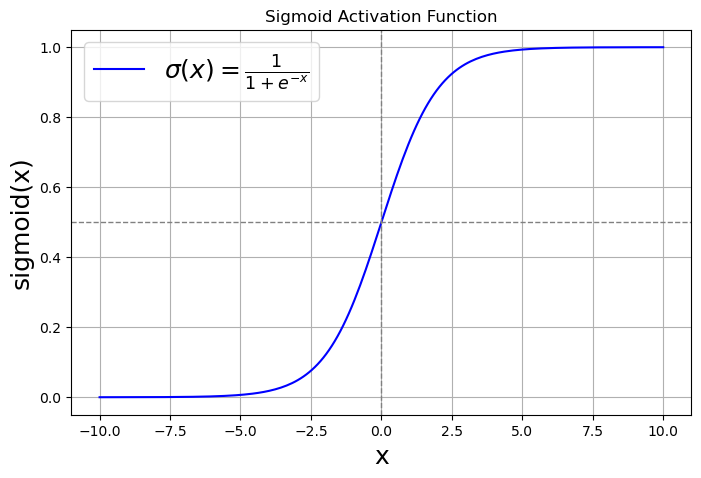

In [63]:
import numpy as np

# Define the activation function
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# Generate x values
x_vals = np.linspace(-10, 10, 200)
y_vals = sigmoid(x_vals)

# Plot the sigmoid curve
plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, label=r"$\sigma(x) = \frac{1}{1 + e^{-x}}$", color="blue")
plt.axhline(0.5, color='gray', linestyle='--', lw=1)
plt.axvline(0, color='gray', linestyle='--', lw=1)
plt.title("Sigmoid Activation Function")
plt.xlabel("x", fontsize=18)
plt.ylabel("sigmoid(x)",fontsize=18)
plt.grid(True)
plt.legend(fontsize=18)
plt.show()


In [ ]:
# Define feature matrix X and target vector y
X = df_clean.iloc[:, :-1].values 
y = df_clean.iloc[:, -1].values

# Split the dataset into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalize the features if ranges are very different
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Initialize Adaline with sigmoid activation
ada_sigmoid = AdalineGD(eta=0.01, n_iter=10, random_state=1, activation=sigmoid)

# Train it
ada_sigmoid.fit(X_train, y_train)

# Evaluate
y_pred_sigmoid = ada_sigmoid.predict(X_test)
acc_sigmoid = accuracy_score(y_test, y_pred_sigmoid)
print(f"Test Accuracy (Adaline + Sigmoid): {acc_sigmoid*100:.2f} %")


Test Accuracy (Adaline + Sigmoid): 70.00%


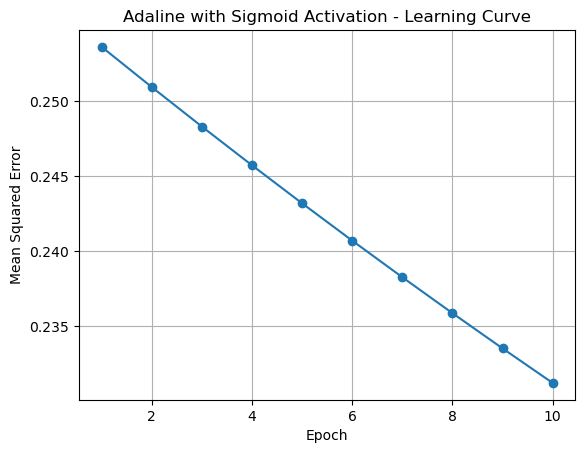

In [68]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(ada_sigmoid.losses_) + 1), ada_sigmoid.losses_, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Adaline with Sigmoid Activation - Learning Curve')
plt.grid(True)
plt.show()

### Can you apply the Perceptron/Adaline to PID ?